In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
from numpy import linalg as LA

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [2]:
FILE_NAME = 'trail_128_16_30_5_seed1'
DATA_DIR = '../../data/'


In [3]:
emb = pd.read_csv(f'./emb/{FILE_NAME}.csv', index_col=0)

k_emb = emb[emb['type'] == 1].copy(deep=True)
gm_emb = emb[emb['type'] == 2].copy(deep=True)
# gene_emb = emb[emb['type'] == 0].copy(deep=True)

emb.drop('type' , axis='columns', inplace=True)
k_emb.drop('type', axis='columns', inplace=True)
gm_emb.drop('type', axis='columns', inplace=True)
# gene_emb.drop('type', axis='columns', inplace=True)

print(f'K562: {k_emb.shape}')
print(f'GM12878: {gm_emb.shape}')
# print(f'Gene: {gene_emb.shape}')
emb.dtypes

K562: (69, 16)
GM12878: (69, 16)


0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
dtype: object

## Check for normalization

In [4]:
is_normalized = pd.DataFrame(LA.norm(emb.to_numpy(), axis=1), index=emb.index, columns=['sqr_sum'])
is_normalized['is_normalized'] = is_normalized['sqr_sum'].map(lambda x: x - 1 < 1e-5)
from collections import Counter
Counter(is_normalized['is_normalized'])## Plot embedding of TFs

Counter({True: 17171})

The result embedding is indeed normalized

## Plot Embedding of TFs

In [5]:
tf_emb = pd.concat([gm_emb, k_emb])
all_embeddings = tf_emb.to_numpy()
nodes = tf_emb.index.to_numpy()

In [6]:
trans = TSNE(n_components=2, random_state=0)
emb_transformed = pd.DataFrame(trans.fit_transform(all_embeddings), index=nodes)
emb_transformed['type'] = emb_transformed.index.map(lambda name: 1 if name[-2:] == '_k' else 2)


In [7]:
Path(f"./result/{FILE_NAME}").mkdir(parents=True, exist_ok=True)

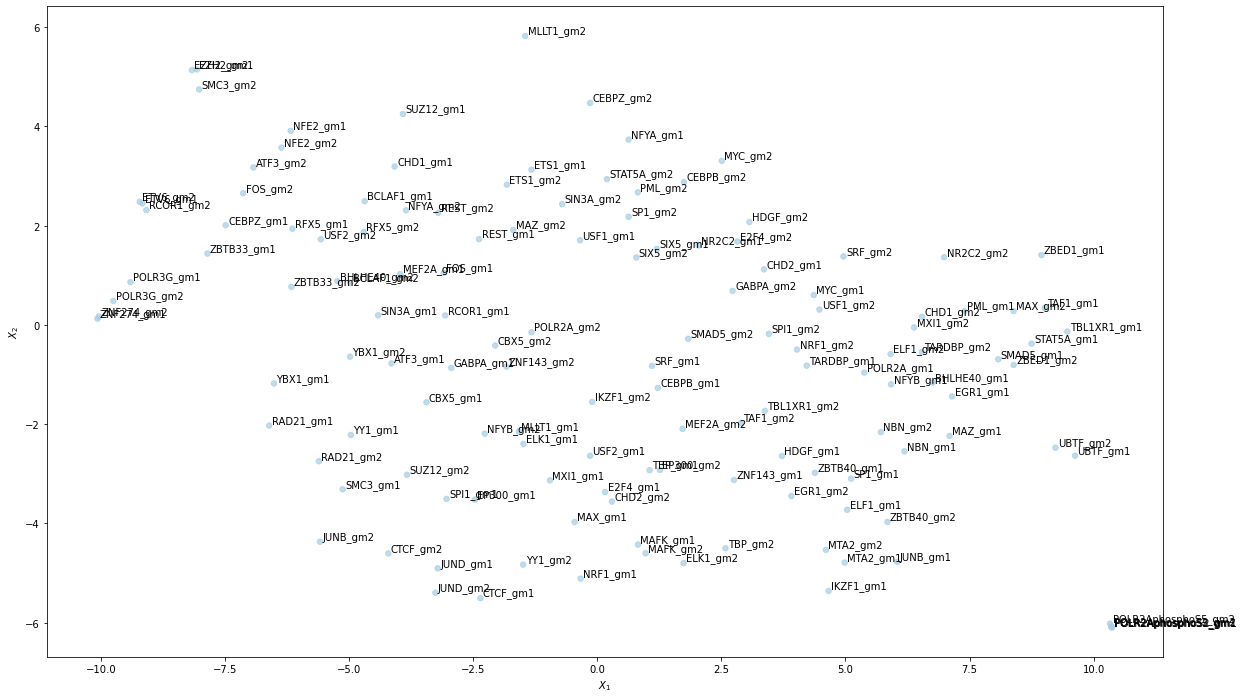

In [8]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["type"],
    cmap="Paired",
    alpha=alpha,
    s=30
)


# mark out some nodes
target_nodes = ['PML', 'NBN', 'MAZ', 'RFX5', 'YBX1', 'MAFK',  'JUND', 'MYC', 'MAX']
target_txts = []
for n in target_nodes:
    target_txts.append(n + '_gm2')
    target_txts.append(n + '_gm1')

TARGETS_ONLY = False
for i, txt in enumerate(nodes):
    if txt in target_txts or not TARGETS_ONLY:
        ax.annotate(txt, (emb_transformed.iloc[i][0]+.05, emb_transformed.iloc[i][1]+.05))
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
# plt.title(f"TSNE visualization of HinSAGE TF embeddings")

plt.savefig(f'./img/TF/{FILE_NAME}_TF.png', dpi=150)
plt.savefig(f'./result/{FILE_NAME}/TF_nolabel.svg', dpi=150)
plt.show()

## Calculate embedding distance
1. Traverse all TFs, calculate L2 distance


In [9]:
tf_names = k_emb.index.map(lambda name: name[:-2]).to_list()
k_names = k_emb.index.to_list()
gm_names = gm_emb.index.to_list()

iterables = [list(gm_names), list(k_names)] 
idx = pd.MultiIndex.from_product(iterables, names=['gm', 'k'])

tf_emb_dist = pd.DataFrame(index=idx, columns=['distance'], dtype=np.float32)
tf_emb_dist['gm_emb'] = tf_emb_dist.index.map(lambda x: gm_emb.loc[x[0]])
tf_emb_dist['k_emb'] = tf_emb_dist.index.map(lambda x: k_emb.loc[x[1]])

def get_dist(x):
    return LA.norm(x[0].to_numpy() - x[1].to_numpy())

tf_emb_dist['distance'] = tf_emb_dist[['gm_emb', 'k_emb']].apply(get_dist, axis=1)

tf_emb_dist

distance                                             gm_emb  \
gm      k                                                                       
EZH2_gm ZBTB33_k  0.518595  0     0.000000
1     0.000000
2     0.000000
3...   
        RFX5_k    0.366545  0     0.000000
1     0.000000
2     0.000000
3...   
        ELF1_k    0.515973  0     0.000000
1     0.000000
2     0.000000
3...   
        USF1_k    0.542667  0     0.000000
1     0.000000
2     0.000000
3...   
        NR2C2_k   0.620678  0     0.000000
1     0.000000
2     0.000000
3...   
...                    ...                                                ...   
CTCF_gm NRF1_k    0.094221  0     0.000000
1     0.000000
2     0.000000
3...   
        MAX_k     0.119768  0     0.000000
1     0.000000
2     0.000000
3...   
        ETS1_k    0.071428  0     0.000000
1     0.000000
2     0.000000
3...   
        NFYB_k    0.202918  0     0.000000
1     0.000000
2     0.000000
3...   
        SMAD5_k   0.115699  0     0.000000
1     0.000000
2     0.000000
3...   

                                                              k_emb  
gm      k                                                            
EZH2_gm ZBTB33_k  0     0.022184
1     0.000000
2     0.000000
3...  
        RFX5_k    0     0.005832
1     0.000000
2     0.000000
3...  
        ELF1_k    0     0.021799
1     0.000000
2     0.000000
3...  
        USF1_k    0     0.015990
1     0.000000
2     0.000000
3...  
        NR2C2_k   0     0.011097
1     0.000000
2     0.000000
3...  
...                                                             ...  
CTCF_gm NRF1_k    0     0.031827
1     0.000000
2     0.000000
3...  
        MAX_k     0     0.000000
1     0.000000
2     0.000000
3...  
        ETS1_k    0     0.027725
1     0.000000
2     0.000000
3...  
        NFYB_k    0     0.000000
1     0.000000
2     0.000000
3...  
        SMAD5_k   0     0.009206
1     0.000000
2     0.000000
3...  

[4761 rows x 3 columns]

We sort the DataFrame according to distance

In [10]:
tf_emb_dist_sorted = tf_emb_dist.sort_values(['gm', 'distance'], ascending=False)
tf_emb_dist_sorted.drop(['gm_emb', 'k_emb'], axis=1, inplace=True)
tf_emb_dist_sorted

distance
gm        k                 
ZNF274_gm MAX_k     0.621754
          PML_k     0.608458
          NR2C2_k   0.606423
          ETV6_k    0.604875
          GABPA_k   0.604673
...                      ...
ATF3_gm   TARDBP_k  0.096106
          YY1_k     0.095545
          SMAD5_k   0.092542
          ZBTB33_k  0.088456
          JUNB_k    0.083297

[4761 rows x 1 columns]

Pairwised distance of TFs

In [11]:
tfs = list(pd.read_csv(Path(DATA_DIR) / 'common_tf.csv')['tf'])
pair_dist = {}
for tf in tfs:
    gm = tf + '_gm'
    k = tf + '_k'
    pair_dist[tf] = tf_emb_dist.loc[gm].loc[k]['distance']
pair_dist = pd.DataFrame.from_dict(pair_dist, orient='index', columns=['distance'])
pair_dist.sort_values(['distance'], ascending=True, inplace=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pair_dist)

pair_dist.to_csv(f'./result/{FILE_NAME}/tfranking.csv')

,distance
ELF1,0.059148
ZBTB40,0.070749
ETS1,0.073207
NR2C2,0.075841
ELK1,0.076738
CEBPZ,0.084788
SIX5,0.086840
SRF,0.087985
NRF1,0.088604
GABPA,0.089683
